In [15]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Load your dataset
base_dir='datasets/mt/'
train_data = pd.read_csv(base_dir + 'train.csv')
val_data = pd.read_csv(base_dir + 'valid.csv')
test_data = pd.read_csv(base_dir + 'test.csv')
# Ensure your dataset has 'source' and 'target' columns
train_source_texts = train_data['indonesian'].values
train_target_texts = train_data['english'].values

val_source_texts = val_data['indonesian'].values
val_target_texts = val_data['english'].values

test_source_texts = test_data['indonesian'].values
test_target_texts = test_data['english'].values

In [16]:
# Add special tokens to your training data
train_target_texts = ["<SOS> " + text + " <EOS>" for text in train_target_texts]
val_target_texts = ["<SOS> " + text + " <EOS>" for text in val_target_texts]
test_target_texts = ["<SOS> " + text + " <EOS>" for text in test_target_texts]


In [17]:
train_target_texts

['<SOS> Enjoy 0% instalment for up to 12 months when ordering an Air Asia plane ticket with BNI Credit Card! <EOS>',
 "<SOS> The cakes give me massive nostalgia. Everything is old school. from the presentation to the taste. They're great and inexpensive <EOS>",
 '<SOS> Mom once worked for grab indonesia. <EOS>',
 "<SOS> I love having lunch here the most, thanks to their delicious chicken and sambal, also the price is dirt cheap. The taste of the chicken just seeps to the bone, and the iced aloe vera drink is also fresh, perfect to cool off my stomach after eating the spicy sambal. The servers are swift and kind, and what I like is that in the cashier there's a writing that says 10% of the profit will be donated to charity, making the meal feel even better to my stomach. <EOS>",
 '<SOS> The DAMRI Bus service is really good <EOS>',
 '<SOS> Wanna make some posts with contents that educate Gojek customers. <EOS>',
 '<SOS> Hundreds of houses in Medan were submerged by the flood <EOS>',
 "<S

In [18]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [19]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Define maximum sequence lengths (modify as needed)
max_source_length = max(len(seq) for seq in train_source_sequences)
max_target_length = max(len(seq) for seq in train_target_sequences)

# Pad sequences to ensure uniform length
train_source_sequences = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
train_target_sequences = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

val_source_sequences = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
val_target_sequences = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

test_source_sequences = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
test_target_sequences = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_source_sequences, train_target_sequences))
val_dataset = tf.data.Dataset.from_tensor_slices((val_source_sequences, val_target_sequences))
test_dataset = tf.data.Dataset.from_tensor_slices((test_source_sequences, test_target_sequences))

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Print dataset samples to verify
for source, target in train_dataset.take(1):
    print('Source batch shape:', source.shape)
    print('Target batch shape:', target.shape)


Source batch shape: (32, 77)
Target batch shape: (32, 109)


In [20]:
#
# Encoder
#
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.enc_units,
            return_sequences=False,  # Set to True if you need the full sequence
            return_state=True,       # Set to True if you want the last state
            recurrent_initializer="glorot_uniform",
        )

    def call(self, x):
        x = self.embedding(x)
        output, state = self.rnn(x)  # Get both output and last state
        return state  # Return the last hidden state


In [21]:
#
# Decoder
#
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.SimpleRNN(
            self.dec_units,
            return_sequences=True,  # Set to True to return the full sequence
            return_state=True,      # Set to True to return the last state
            recurrent_initializer="glorot_uniform",
        )
        self.softmax = tf.keras.layers.Dense(vocab_size, activation="softmax")

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.rnn(inputs=x, initial_state=hidden)  # Use SimpleRNN here
        output = self.softmax(output)
        return output, state

In [22]:
# ========================================
# Create model
# ========================================

embedding_dim = 256
units = 1024  # LSTM/GRU dimensionality of the output space.

encoder = Encoder(source_vocab_size, embedding_dim, units, batch_size)
decoder = Decoder(target_vocab_size, embedding_dim, units, batch_size)

optimizer = tf.compat.v1.train.AdamOptimizer()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # this masks '<pad>'
    """
    Example:

    real= tf.Tensor(
    [[21  1 44 0  0]   (jump !    <eos> <pad> <pad>)
    [ 17  9 24 2 44]   (i    go   there .     <eos>)
    [ 27  1 44 0  0]   (no   !    <eos> <pad> <pad>)
    [ 21 22 32 2 44]], (i    know you   .     <eos>)
    , shape=(4, 5), dtype=int64)

    where <pad> = 0.

    mask= tf.Tensor(
    [[True  True  True False False]
    [ True  True  True True  True ]
    [[True  True  True False False]
    [ True  True  True True  True ],
    shape=(4, 5), dtype=bool)
    """

    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [23]:
CHECKPOINT = True

In [24]:
# ========================================
# Training
# ========================================

checkpoint_path = (
    "./checkpointsRNN/seq2seq-sample-"
    + str(500)
    + "-embedding-"
    + str(embedding_dim)
    + "-hidden-"
    + str(units)
)

if CHECKPOINT == True:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Latest checkpoint restored!!")


@tf.function
def train(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    with tf.GradientTape() as tape:
        context_vector = encoder(source_sentences)

        dec_input = target_sentences[:, :-1]  # Decoder input
        expected_dec_output = target_sentences[:, 1:]  # Expected output

        predictions, _ = decoder(dec_input, context_vector)
        loss = loss_function(expected_dec_output, predictions)
        train_accuracy(expected_dec_output, predictions)

    batch_loss = loss / int(target_sentences.shape[1])
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


@tf.function
def validate(encoder, decoder, source_sentences, target_sentences, target_lang_tokenizer):
    context_vector = encoder(source_sentences)
    dec_input = target_sentences[:, :-1]  # Decoder input
    expected_dec_output = target_sentences[:, 1:]  # Expected output

    predictions, _ = decoder(dec_input, context_vector)
    loss = loss_function(expected_dec_output, predictions)
    val_accuracy(expected_dec_output, predictions)  # Assuming you have val_accuracy defined

    return loss


# Set n_epochs at least 20 when you do training.
n_epochs = 40

# Prepare to store loss and accuracy
loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

import time
for epoch in range(1, n_epochs + 1):
    start = time.time()

    total_loss = 0
    total_val_loss = 0
    train_accuracy.reset_states()
    val_accuracy.reset_states()  # Reset validation accuracy

    # Training loop
    for (batch, (source_sentences, target_sentences)) in enumerate(train_dataset):
        batch_loss = train(encoder, decoder, source_sentences, target_sentences, target_tokenizer)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy: {:.4f}".format(epoch, batch, batch_loss.numpy(), train_accuracy.result()))

    # Store the average loss and accuracy for this epoch
    avg_loss = total_loss / (batch + 1)
    loss_history.append(avg_loss)
    accuracy_history.append(train_accuracy.result().numpy())

    # Validation loop
    for (val_source_sentences, val_target_sentences) in val_dataset:
        val_loss = validate(encoder, decoder, val_source_sentences, val_target_sentences, target_tokenizer)
        total_val_loss += val_loss

    # Store the average validation loss and accuracy for this epoch
    avg_val_loss = total_val_loss / len(val_dataset)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy.result().numpy())

    if CHECKPOINT == True:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch, ckpt_save_path))

    print("Epoch {}/{} Loss {:.4f} Val Loss {:.4f}".format(epoch, n_epochs, avg_loss, avg_val_loss))
    print("Time taken for 1 epoch {:.4f} sec\n".format(time.time() - start))


Epoch 1 Batch 0 Loss 0.0255 Accuracy: 0.0006
Saving checkpoint for epoch 1 at ./checkpointsRNN/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-1
Epoch 1/40 Loss 0.0202 Val Loss 1.3994
Time taken for 1 epoch 1.4836 sec

Epoch 2 Batch 0 Loss 0.0154 Accuracy: 0.0075
Saving checkpoint for epoch 2 at ./checkpointsRNN/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-2
Epoch 2/40 Loss 0.0173 Val Loss 1.7796
Time taken for 1 epoch 0.8239 sec

Epoch 3 Batch 0 Loss 0.0199 Accuracy: 0.0087
Saving checkpoint for epoch 3 at ./checkpointsRNN/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-3
Epoch 3/40 Loss 0.0174 Val Loss 1.3925
Time taken for 1 epoch 0.8321 sec

Epoch 4 Batch 0 Loss 0.0179 Accuracy: 0.0177
Saving checkpoint for epoch 4 at ./checkpointsRNN/seq2seq-sample-500-embedding-256-hidden-1024/ckpt-4
Epoch 4/40 Loss 0.0170 Val Loss 1.3833
Time taken for 1 epoch 0.8264 sec

Epoch 5 Batch 0 Loss 0.0180 Accuracy: 0.0223
Saving checkpoint for epoch 5 at ./checkpointsRNN/seq2seq-sample-500-em

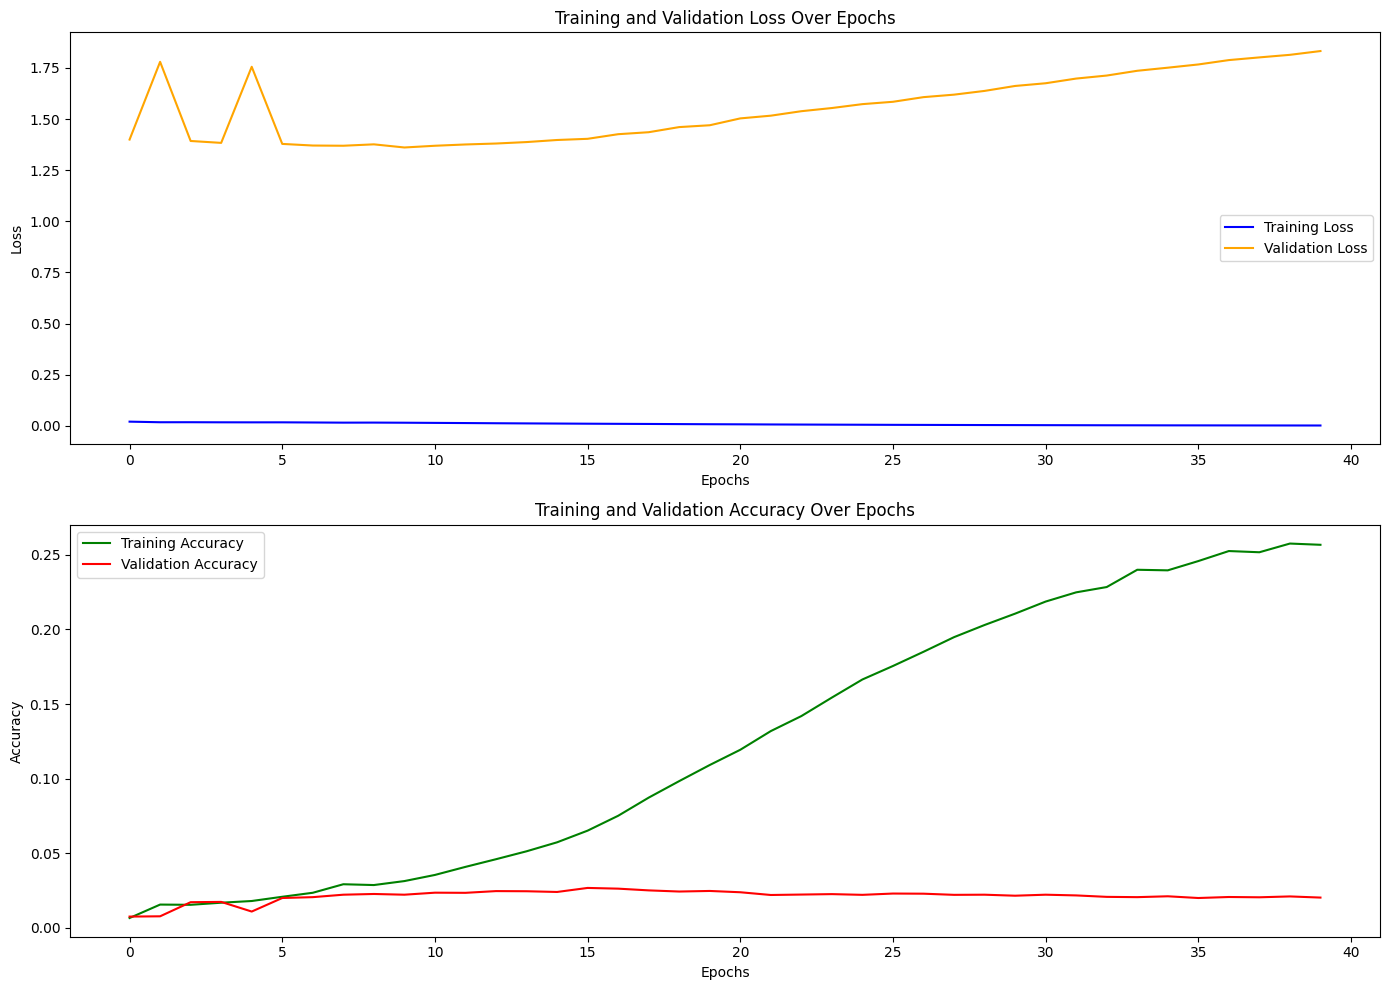

In [25]:
import matplotlib.pyplot as plt
# Plotting Loss and Accuracy
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(accuracy_history, label='Training Accuracy', color='green')
plt.plot(val_accuracy_history, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [26]:
target_tokenizer.word_index

{'the': 1,
 'sos': 2,
 'eos': 3,
 'and': 4,
 'to': 5,
 'a': 6,
 'is': 7,
 'of': 8,
 'i': 9,
 'for': 10,
 'was': 11,
 'in': 12,
 'it': 13,
 'with': 14,
 'that': 15,
 'my': 16,
 'this': 17,
 'food': 18,
 'just': 19,
 'you': 20,
 'place': 21,
 'also': 22,
 'so': 23,
 'we': 24,
 'but': 25,
 "it's": 26,
 'are': 27,
 'here': 28,
 'from': 29,
 'good': 30,
 'at': 31,
 'not': 32,
 'as': 33,
 'all': 34,
 'on': 35,
 'price': 36,
 'be': 37,
 'when': 38,
 'because': 39,
 'really': 40,
 'there': 41,
 'can': 42,
 'has': 43,
 'out': 44,
 'too': 45,
 'were': 46,
 'time': 47,
 'have': 48,
 'if': 49,
 'even': 50,
 'they': 51,
 'menu': 52,
 'like': 53,
 'very': 54,
 'great': 55,
 'or': 56,
 'more': 57,
 'restaurant': 58,
 'by': 59,
 'fried': 60,
 'taste': 61,
 'pretty': 62,
 'your': 63,
 'me': 64,
 'delicious': 65,
 'lot': 66,
 'people': 67,
 'about': 68,
 'service': 69,
 'family': 70,
 'our': 71,
 'resto': 72,
 'had': 73,
 'one': 74,
 'no': 75,
 'got': 76,
 'an': 77,
 "there's": 78,
 'perfect': 79,
 'eat

In [27]:
# ========================================
# Translation
# ========================================

def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])

keys = np.arange(len(val_source_sequences))
keys = np.random.permutation(keys)[:10]

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(val_source_sequences[i], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    print("Correct  : {}".format(detokenize(val_target_sequences[i],target_tokenizer)))

encoder.summary()
decoder.summary()
decoder.get_config()

===== [1] ======
Input    : jika ada lebih yang ingin kamu atau kendala terkait dengan produk traveloka jangan ragu untuk menghubungi kami kembali
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu is non halal eos 
Correct  : sos if you have questions you'd like to ask or have issues regarding products be sure to contact us again eos
===== [2] ======
Input    : rasanya sih kok harga kaki lima dan rasanya ya tidak jauh dari situ ya tempatnya saja sih restoran kalau soal rasa ya
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu is non halal eos 
Correct  : sos i why the cost is pedestrian and well turns out the taste is not that far off yeah only the place looks the part of a restaurant but the taste well y'know eos
===== [3] ======
Input    : minimal cek pesan saya ada yang ada di
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu 

{'vocab_size': 2865, 'embedding_dim': 256, 'dec_units': 1024, 'batch_sz': 32}

In [28]:
# ========================================
# Translation
# ========================================
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
import nltk
def evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):

    inputs = source_lang_tokenizer.texts_to_sequences([sentence])[0]

    inputs = tf.compat.v1.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_source_length, padding="post"
    )
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    context_vector = encoder(inputs)
    dec_hidden = context_vector
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index["sos"]], 0)

    for t in range(max_target_length):
        #
        # Greedy Search
        #
        predictions, dec_hidden = decoder(dec_input, dec_hidden)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + " "
        if target_lang_tokenizer.index_word[predicted_id] == "eos":
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


def translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer):
    result = evaluate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
    return result.capitalize()

"""
# for debug:
#sentence = "Su voz suena muy bello."
#sentence = "No nos gusta la lluvia."
sentence = "Nos gusta la lluvia."
result = translate(sentence, encoder, decoder, source_lang_tokenizer, target_lang_tokenizer)
print("Input    : {}".format(sentence))
print("Predicted: {}".format(result))

sys.exit()
"""
#
#
# Helper function to detokenize a sequence to text
def detokenize(sequence, tokenizer):
    return ' '.join([tokenizer.index_word.get(idx, '') for idx in sequence if idx != 0])


# Set the NLTK data path


def calculate_bleu(reference, hypothesis):
    # Tokenize the sentences for BLEU score calculation

    # Use the sentence_bleu function to calculate the score
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
    return bleu_score

# ... (rest of your existing code)

keys = np.arange(len(val_source_sequences))
keys = np.random.permutation(keys)[:10]

bleu_scores = []

for i in range(len(keys)):
    print("===== [{}] ======".format(i + 1))
    sentence = detokenize(val_source_sequences[keys[i]], source_tokenizer)
    result = translate(sentence, encoder, decoder, source_tokenizer, target_tokenizer)
    print("Input    : {}".format(sentence))
    print("Predicted: {}".format(result))
    correct_sentence = detokenize(val_target_sequences[keys[i]], target_tokenizer)
    print("Correct  : {}".format(correct_sentence))
    
    # Calculate and store the BLEU score
    bleu_score = calculate_bleu(correct_sentence, result)
    bleu_scores.append(bleu_score)
    print("BLEU Score: {:.4f}".format(bleu_score))

# Calculate the average BLEU score for the sample
average_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score for the sample: {:.4f}".format(average_bleu_score))

# Optionally, summarize encoder and decoder
# encoder.summary()
# decoder.summary()
# decoder.get_config()

===== [1] ======
Input    : tidak ada duanya deh semoga
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu is non halal eos 
Correct  : sos no contest hope the is long eos
BLEU Score: 0.0031
===== [2] ======
Input    : yang terhormat bank bca sepertinya anda harus menambah jumlah personil pelayanan pelanggan officer deh daripada bank besar pelayanan payah
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu is non halal eos 
Correct  : sos to it may in bca bank i think you should the number of customer service you wouldn't want to be as a huge bank with crap service don't you eos
BLEU Score: 0.0035
===== [3] ======
Input    : tidak memuaskan ingin marah marah sama itu pelayanan pelanggan
Predicted: The place is interesting with a very industrial concept a shame that almost all of the menu is non halal eos 
Correct  : sos the answer is not satisfying i want to that customer service eos


: 